<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/Prophet/By_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

from datetime import date
import holidays

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

# Methods


In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['ds','cat','y'], 
      parse_dates = True )
  df_doc['ds'] = pd.to_datetime(df_doc['ds'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['ds','y']].reset_index(drop=True)

In [0]:
def split_train_test(df_filter, date_start_test):
  split_point = df_filter[df_filter['ds']==date_start_test].index[0]
  train = df_filter[:split_point]
  test = df_filter[split_point:]
  return [train, test]

In [0]:
def compare_dates(date_begin, date_end, forecast, data):
  yhat = forecast[(forecast['ds'] >= date_begin) & (forecast['ds'] <= date_end)][['ds','yhat']][['ds','yhat']]
  yreal = data[(data['ds'] >= date_begin) & (data['ds'] <= date_end)]
  merged_inner = pd.merge(left=yreal,right=yhat, left_on='ds', right_on='ds')
  return merged_inner

In [0]:
def get_df_holidays(year_list):
  us_holidays = holidays.UnitedStates()
  mylist = []
  for date, name in sorted(holidays.US(years=year_list).items()):
    mylist.append((name,date,0,0))
  df_holidays = pd.DataFrame(mylist, columns = ['holiday' , 'ds', 'lower_window' , 'upper_window'])

# Data preparation

In [0]:
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
df_doc = read_raw_csv(url, 4167)
df_filter = filter_by(df_doc, 'Robert Caputo')

In [0]:
df_filter = df_filter.set_index(pd.DatetimeIndex(df_filter['ds']))
df_filter = df_filter.drop('ds', axis=1)
revenue_x_m = df_filter.groupby([df_filter.index.year, df_filter.index.month]).sum()
revenue_x_m['info'] = revenue_x_m.index
revenue_x_m = revenue_x_m.reset_index(drop=True)
revenue_x_m['ds'] = revenue_x_m['info'].apply(lambda x : str(x[0])+'-'+str(x[1]))
revenue_x_m['ds'] = pd.to_datetime(revenue_x_m['ds'])+pd.tseries.offsets.MonthEnd(0)
revenue_x_m = revenue_x_m.drop('info', axis=1)

In [0]:
revenue_x_m = revenue_x_m[revenue_x_m['ds']>'2016-02-29']
revenue_x_m = revenue_x_m[revenue_x_m['ds']<'2019-12-31']
revenue_x_m = revenue_x_m[['ds', 'y']]

In [0]:
[train,test] = split_train_test(revenue_x_m, '2019-05-31')

In [193]:
print(train.shape)
print(test.shape)
test

(39, 2)
(6, 2)


,ds,y
40,2019-06-30,108978.16
41,2019-07-31,114450.48
42,2019-08-31,110036.84
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


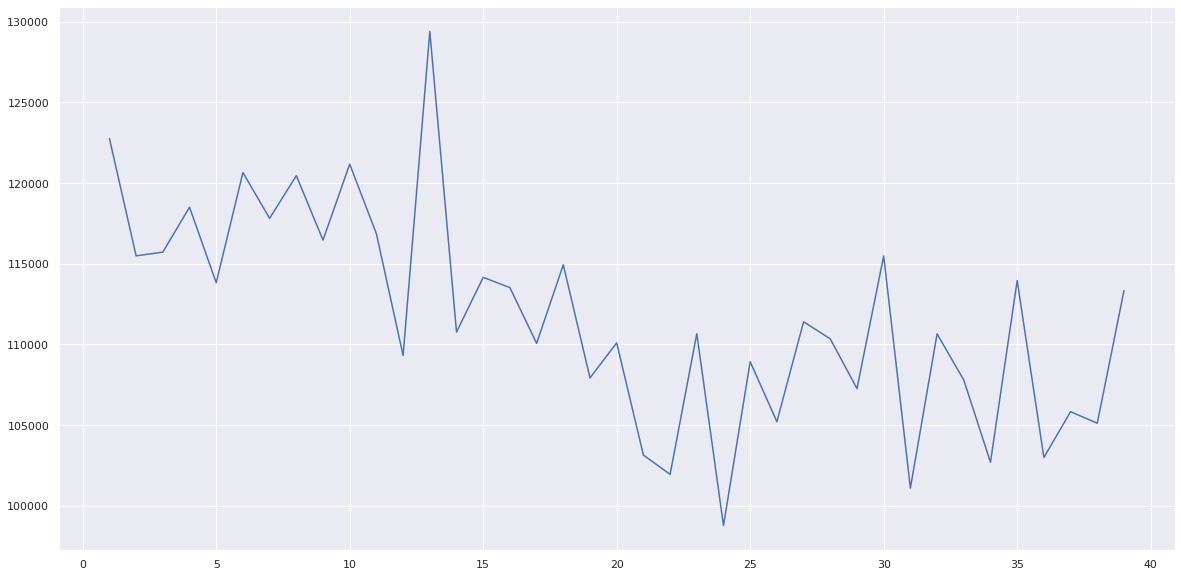

In [197]:
plt.plot(train['y'])

In [198]:
print(revenue_x_m['y'].min())
print(revenue_x_m['y'].mean())
print(revenue_x_m['y'].median())
print(revenue_x_m['y'].std())
print(revenue_x_m['y'].max())

98779.56000000001
113050.54488888892
110767.21
10669.198671933797
166835.02000000005


# Simple Model

In [199]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=6, freq='m')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [202]:
  predict = forecast[(forecast['ds'] >= '2019-06-30') & (forecast['ds'] <= '2019-11-30')]
  predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
39,2019-06-30,110046.139147,108905.823342,112691.280251,109986.391900,110092.980299,723.311212,723.311212,723.311212,723.311212,723.311212,723.311212,0.0,0.0,0.0,110769.450359
40,2019-07-31,110151.217408,107291.703864,111232.173596,109918.553612,110373.753499,-896.994125,-896.994125,-896.994125,-896.994125,-896.994125,-896.994125,0.0,0.0,0.0,109254.223283
41,2019-08-31,110256.295669,115907.083238,119965.226159,109779.021722,110703.297569,7617.545830,7617.545830,7617.545830,7617.545830,7617.545830,7617.545830,0.0,0.0,0.0,117873.841500
42,2019-09-30,110357.984309,96962.881990,101274.582286,109621.234964,111072.339037,-11192.599957,-11192.599957,-11192.599957,-11192.599957,-11192.599957,-11192.599957,0.0,0.0,0.0,99165.384352
43,2019-10-31,110463.062570,109732.906127,114126.724079,109400.154930,111522.298146,1496.285513,1496.285513,1496.285513,1496.285513,1496.285513,1496.285513,0.0,0.0,0.0,111959.348083
44,2019-11-30,110564.751210,107068.292100,111732.787520,109139.882097,111953.907616,-1360.848324,-1360.848324,-1360.848324,-1360.848324,-1360.848324,-1360.848324,0.0,0.0,0.0,109203.902886


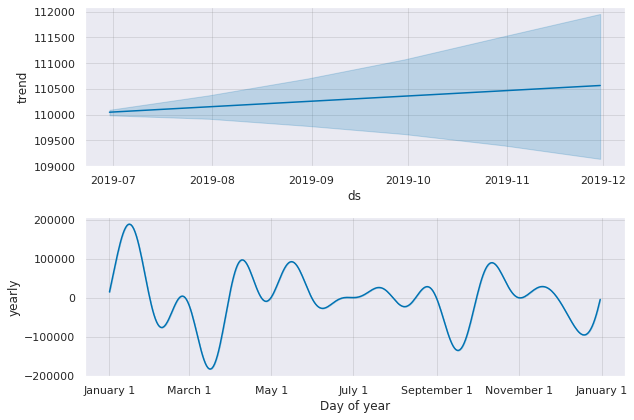

In [203]:
fig_decompose = m.plot_components(predict)

In [204]:
compare_dates('2019-06-30', '2019-11-30', forecast, test)

,ds,y,yhat
0,2019-06-30,108978.16,110769.450359
1,2019-07-31,114450.48,109254.223283
2,2019-08-31,110036.84,117873.841500
3,2019-09-30,102553.42,99165.384352
4,2019-10-31,166835.02,111959.348083
5,2019-11-30,127871.36,109203.902886


# Fourier Model order 5

In [205]:
print(train.shape)
print(test.shape)
test

(39, 2)
(6, 2)


,ds,y
40,2019-06-30,108978.16
41,2019-07-31,114450.48
42,2019-08-31,110036.84
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


In [0]:
m = Prophet(
    weekly_seasonality=False, 
    daily_seasonality=False, 
    n_changepoints=2)
m.add_seasonality(
    name='monthly', 
    period=30.5, 
    fourier_order=5)
m.fit(train)
future = m.make_future_dataframe(periods=6, freq='M')
forecast1 = m.predict(future)

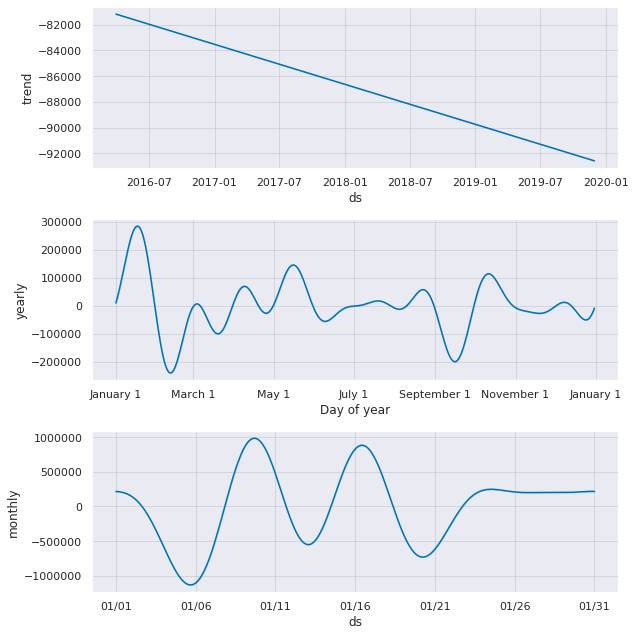

In [207]:
fig_decompose = m.plot_components(forecast1)

In [208]:
compare_dates('2019-06-30', '2019-11-30', forecast1, test)

,ds,y,yhat
0,2019-06-30,108978.16,113880.397668
1,2019-07-31,114450.48,104188.836793
2,2019-08-31,110036.84,113463.272110
3,2019-09-30,102553.42,91859.730981
4,2019-10-31,166835.02,105216.837432
5,2019-11-30,127871.36,99933.667729


# Model with Holidays

In [209]:
print(train.shape)
print(test.shape)
test

(39, 2)
(6, 2)


,ds,y
40,2019-06-30,108978.16
41,2019-07-31,114450.48
42,2019-08-31,110036.84
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


In [0]:
df_holidays = get_df_holidays([2016,2017,2018,2019])
m = Prophet(holidays=df_holidays,daily_seasonality=True,weekly_seasonality=True)
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=6, freq='m')
forecast2 = m.predict(future)

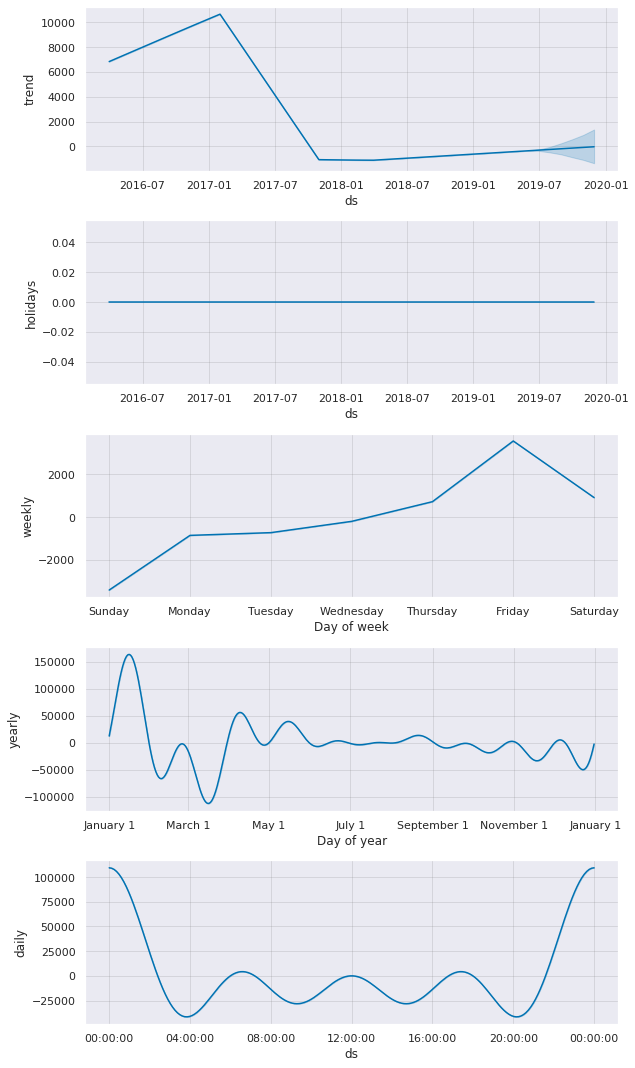

In [212]:
fig_decompose = m.plot_components(forecast2)

In [213]:
compare_dates('2019-06-30', '2019-11-30', forecast2, test)

,ds,y,yhat
0,2019-06-30,108978.16,105291.520188
1,2019-07-31,114450.48,108193.823537
2,2019-08-31,110036.84,114100.537741
3,2019-09-30,102553.42,105235.720502
4,2019-10-31,166835.02,112520.653429
5,2019-11-30,127871.36,104385.883214


# Compare Models

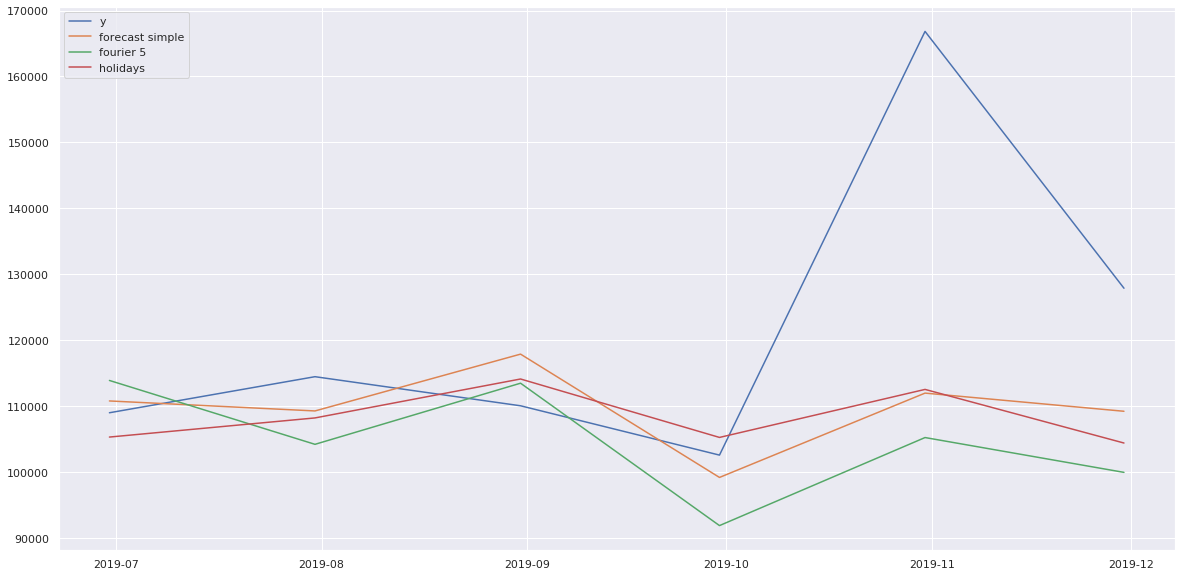

In [214]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(revenue_x_m[revenue_x_m['ds'] >= '2019-06-30']['ds'], revenue_x_m[revenue_x_m['ds'] >= '2019-06-30']['y'], label='y')
plt.plot(forecast[forecast['ds'] >= '2019-06-30']['ds'], forecast[forecast['ds'] >= '2019-06-30']['yhat'], label='forecast simple')
plt.plot(forecast1[forecast1['ds'] >= '2019-06-30']['ds'], forecast1[forecast1['ds'] >= '2019-06-30']['yhat'], label='fourier 5')
plt.plot(forecast2[forecast2['ds'] >= '2019-06-30']['ds'], forecast2[forecast2['ds'] >= '2019-06-30']['yhat'], label='holidays')
plt.legend(loc="upper left")